# Time series - recurrent network text

In this example, we will predict a very simple artificial time series. We can look at it as a regression in time.

In [0]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN

TensorFlow 2.x selected.


This is what we are going to predict: A cumulative sum of a random input value. Here's how it looks like:

$
\begin{align}
y_t = tanh(\sum_{i=1}^t x_i)
\end{align}
$

Hyperbolic tangent is there just for keeping it in a reasonable output interval.

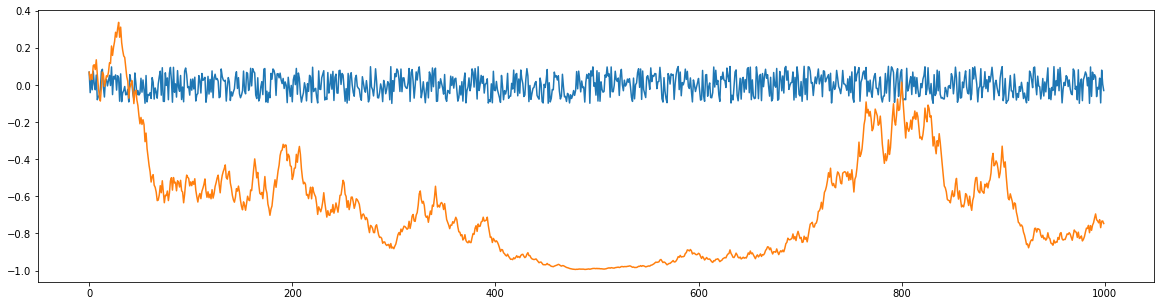

In [0]:
samples = np.random.uniform(low=-0.1, high=0.1, size=(1000))

plt.figure(figsize=(20,5))
plt.plot(samples)
plt.plot(np.tanh(np.cumsum(samples)))
plt.show()

Next, we are going to prepare a training set. We'll sample the same function a few thousand times:

In [0]:
NUM_SAMPLES = 2000
SEQ_LEN = 200

raw_train_X = [np.random.uniform(low=-0.1, high=0.1, size=(SEQ_LEN)) for i in range(NUM_SAMPLES)]
raw_train_Y = [np.tanh(np.cumsum(x)) for x in raw_train_X]

## Feed forward network

Now, let's build a simple feed-forward network for prediction of this series. Notice that it has to have the whole sequence on the input.

In [0]:
inputs = Input(shape=(SEQ_LEN,))
x = Dense(200, activation='tanh')(inputs)
x = Dense(200, activation='tanh')(x)
x = Dense(200, activation='tanh')(x)
outputs = Dense(SEQ_LEN, activation='tanh')(x)

ffn_model = Model(inputs, outputs)
ffn_model.compile(optimizer='adam', loss='mse')
ffn_model.summary()

train_X = np.vstack(raw_train_X)
train_Y = np.vstack(raw_train_Y)

print("Input shape:", train_X.shape)
print("Target shape:", train_Y.shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
Total params: 160,800
Trainable params: 160,800
Non-trainable params: 0
_________________________________________________________________
Input shape: (2000, 200)
Target shape: (2000, 200)


Now we can fit the training data:

In [0]:
progress = ffn_model.fit(train_X, train_Y, validation_split=0.1, epochs=25)

Train on 1800 samples, validate on 200 samples
Epoch 1/25
1800/1800 [==============================] - 0s 116us/sample - loss: 7.3710e-04 - val_loss: 7.4504e-04
Epoch 2/25
1800/1800 [==============================] - 0s 111us/sample - loss: 8.4560e-04 - val_loss: 8.7317e-04
Epoch 3/25
1800/1800 [==============================] - 0s 113us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 4/25
1800/1800 [==============================] - 0s 150us/sample - loss: 0.0010 - val_loss: 0.0012
Epoch 5/25
1800/1800 [==============================] - 0s 108us/sample - loss: 0.0013 - val_loss: 9.9886e-04
Epoch 6/25
1800/1800 [==============================] - 0s 110us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 7/25
1800/1800 [==============================] - 0s 115us/sample - loss: 9.7753e-04 - val_loss: 8.6435e-04
Epoch 8/25
1800/1800 [==============================] - 0s 129us/sample - loss: 8.4725e-04 - val_loss: 8.0099e-04
Epoch 9/25
1800/1800 [==============================] - 0s 131us/samp

Let's test out the model on newly generated sequence.

In [0]:
test_sample = np.random.uniform(low=-0.1, high=0.1, size=(SEQ_LEN))

Let's see how our model performs on a `test_sample`

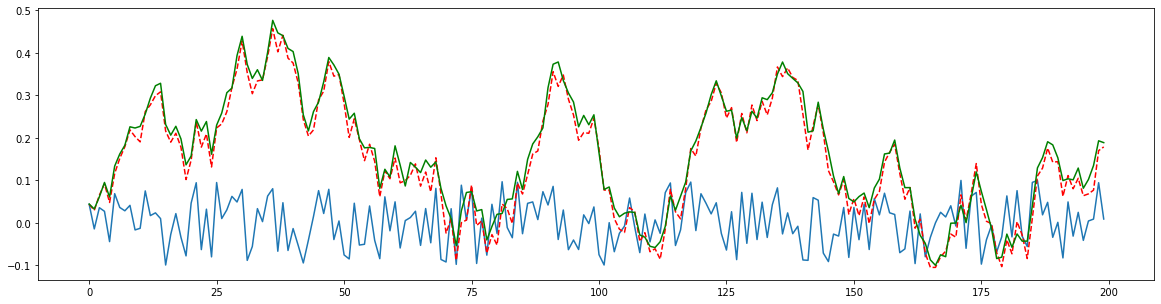

In [0]:
prediction = ffn_model.predict(test_sample.reshape((1, SEQ_LEN)))[0]

plt.figure(figsize=(20,5))
plt.plot(test_sample)
plt.plot(np.tanh(np.cumsum(test_sample)), 'r--')
plt.plot(prediction, 'g-')
plt.show()

Or let's make some non-standard test sample with leading zeros. We can confirm if and how much future input values affect past output values (one downside of using feed-forward nets for time series prediction)

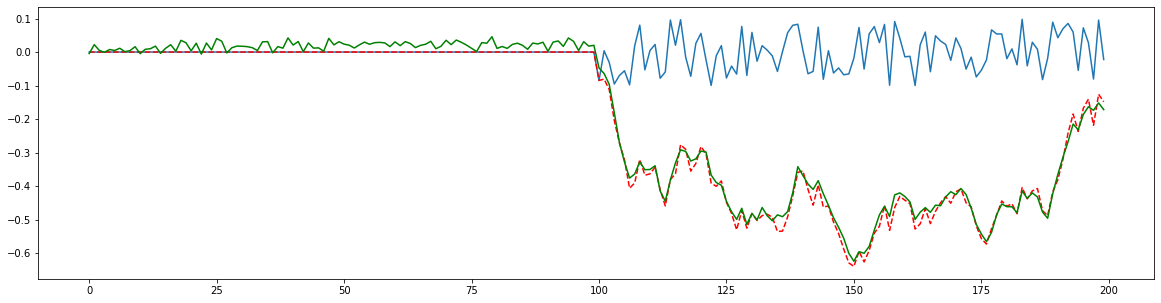

In [0]:
test_sample_zeroes = np.concatenate([np.zeros(100), np.random.uniform(low=-0.1, high=0.1, size=(SEQ_LEN - 100))])
prediction = ffn_model.predict(test_sample_zeroes.reshape((1, SEQ_LEN)))[0]

plt.figure(figsize=(20,5))
plt.plot(test_sample_zeroes)
plt.plot(np.tanh(np.cumsum(test_sample_zeroes)), 'r--')
plt.plot(prediction, 'g-')
plt.show()

## Recurrent networks

Finally let's try some recurrent networks:

In [0]:
inputs = Input(shape=(None, 1))
x = SimpleRNN(32, return_sequences=True)(inputs)
x = SimpleRNN(32, return_sequences=True)(x)
outputs = SimpleRNN(1, return_sequences=True)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X).reshape((NUM_SAMPLES, SEQ_LEN, 1))
train_Y = np.vstack(raw_train_Y).reshape((NUM_SAMPLES, SEQ_LEN, 1))

print("Input shape:", train_X.shape)
print("Target shape:", train_Y.shape)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          1088      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 1)           34        
Total params: 3,202
Trainable params: 3,202
Non-trainable params: 0
_________________________________________________________________
Input shape: (2000, 200, 1)
Target shape: (2000, 200, 1)


Or LSTM recurrent network:

In [0]:
inputs = Input(shape=(None, 1))
x = LSTM(32, return_sequences=True)(inputs)
outputs = Dense(1, activation='tanh')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X).reshape((NUM_SAMPLES, SEQ_LEN, 1))
train_Y = np.vstack(raw_train_Y).reshape((NUM_SAMPLES, SEQ_LEN, 1))

print("Input shape:", train_X.shape)
print("Target shape:", train_Y.shape)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          4352      
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Input shape: (2000, 200, 1)
Target shape: (2000, 200, 1)


In [0]:
progress = model.fit(train_X, train_Y, validation_split=0.1, epochs=25)

Train on 1800 samples, validate on 200 samples
Epoch 1/25
1800/1800 [==============================] - 2s 1ms/sample - loss: 1.2101e-04 - val_loss: 2.0985e-05
Epoch 2/25
1800/1800 [==============================] - 2s 1ms/sample - loss: 3.5319e-05 - val_loss: 1.0021e-04
Epoch 3/25
1800/1800 [==============================] - 2s 1ms/sample - loss: 9.4399e-05 - val_loss: 2.0050e-05
Epoch 4/25
1800/1800 [==============================] - 2s 1ms/sample - loss: 6.3374e-05 - val_loss: 1.4270e-04
Epoch 5/25
1800/1800 [==============================] - 2s 1ms/sample - loss: 7.0612e-05 - val_loss: 7.1108e-05
Epoch 6/25
1800/1800 [==============================] - 2s 1ms/sample - loss: 2.7733e-04 - val_loss: 7.7634e-05
Epoch 7/25
1800/1800 [==============================] - 2s 1ms/sample - loss: 7.1243e-05 - val_loss: 1.0304e-05
Epoch 8/25
1800/1800 [==============================] - 2s 1ms/sample - loss: 1.7983e-05 - val_loss: 9.6747e-06
Epoch 9/25
1800/1800 [==============================] - 2

Now, test it on **5x longer** test sequence

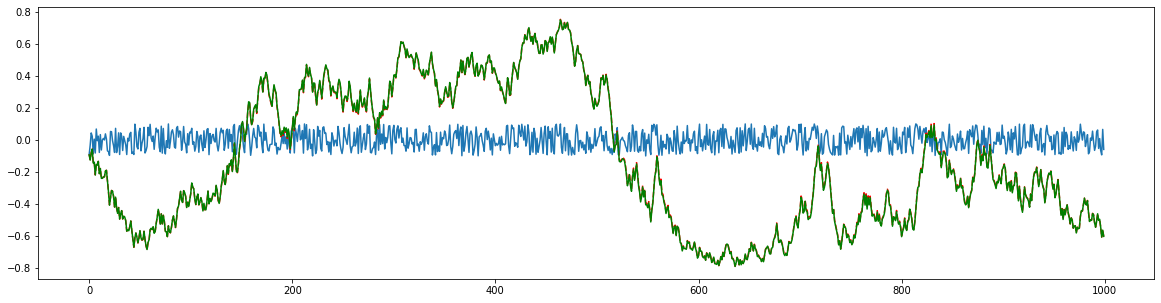

In [0]:
TEST_SEQ_LEN = 1000
test_sample = np.random.uniform(low=-0.1, high=0.1, size=(TEST_SEQ_LEN))

prediction = model.predict(test_sample.reshape((1, TEST_SEQ_LEN, 1)))[0]

plt.figure(figsize=(20,5))
plt.plot(test_sample)
plt.plot(np.tanh(np.cumsum(test_sample)), 'r--')
plt.plot(prediction, 'g-')
plt.show()

In [0]:
#utility code to plot loss history

loss_history = np.array(progress.history['loss'])
val_loss_history = np.array(progress.history['val_loss'])
                            
plt.figure(figsize=(20,5))
plt.ylim(ymin=0, ymax=max(np.max(loss_history), np.max(val_loss_history)))
plt.plot(loss_history, 'r-')
plt.plot(val_loss_history, 'g-')
plt.show()